In [ ]:
import numpy as np

from qiskit import *
from qiskit.visualization import *
from qiskit.quantum_info import *
from qiskit.circuit.library import *
from qiskit.opflow import *

# Quantum Data Encoding

One of the most important process to construct quantum algorithms is the first step where *classical data* needs to be converted into *quantum data*. It is a crucial step to obtain good results, but it has a huge computational cost in terms of preparing a specific wavefunction $|\varphi\rangle$.

A quantum operator can be decomposed into elementary quantum gates, it could be used to obtain a specific state/wavefunction to work with.

In Machine Learning, the process of chaging from the original feature space to other space where the variables have certain properties that help to the model is called *feature map*. It is an esseantial process in classical models and the solution absolutely relys into the selection of the mapping (usually a non-linear function).

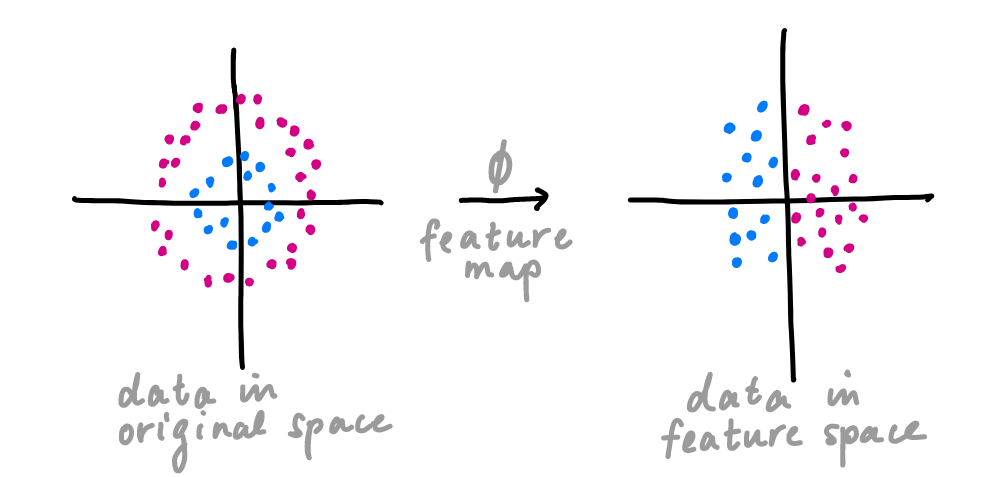

In Quantum Machine Learning, converting classical data from a feature space to a quantum space (or Hilbert space) is also a very important task (perhaps the most important task for current QML algorithms performed in NISQ devices. The *quantum feature map* consists on applying a unitary transformation $U_{\phi}(x)$ to convert the feature space $\mathcal{L}$ into a Hilbert space $\mathcal{H}$ such, $\phi:\mathcal{L}\rightarrow\mathcal{H}$. The aim is to transform the input data $x$ into quantum states $|\phi (x)\rangle$, $x \rightarrow |\phi(x)\rangle$. Hilbert spaces usually are higher order dimension spaces than where the original data remains.

Once the feature map is applied, a kernel is produced: a higher feature space with certain properties where the data points are easier classified. By switching between kernels one effectively switches between different models (classically speaking), which is known as the *kernel trick*. In the quantum case, the *kernel trick* corresponds to changing the data encoding strategy (second generation QML algorithms).  *quantum feature map*.

In the following sections we will see different methods of *quantum feature map*:

## Basis encoding

This type of quantum enconding consists on applying a transformation such the classical information is inserted into the quantum states. The following examples illustrates how this can be done:

We have a $n-array$ classical data like $n = \left[0, 2\right]$, so we want to obtain $|\psi \rangle = \frac{1}{\sqrt{2}}\left[|00\rangle + |10\rangle \right]$. As the basis are the classical data going with a normalization factor.

So, let's use an operator $U$ to perform such operation. It looks like:

$$U |00\rangle = \frac{1}{\sqrt{2}} \left[|00\rangle + |10\rangle \right]$$

Hence, we have now just the first column of the Operator. We will complete the rest of columns with the identity:

$$U = 
\begin{pmatrix}
\frac{1}{\sqrt{2}} & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
\frac{1}{\sqrt{2}} & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{pmatrix}$$

**The matrix above is not Unitary**, a necessary condition to be able to decompose it into elementary quantum gates. Because of this we will use the Gram-Schmidt procedure to obatin it:

$$U = 
\begin{pmatrix}
\frac{-1}{\sqrt{2}} & 0 & \frac{-1}{\sqrt{2}} & 0 \\
0 & 1 & 0 & 0 \\
\frac{-1}{\sqrt{2}} & 0 & \frac{1}{\sqrt{2}} & 0 \\
0 & 0 & 0 & 1
\end{pmatrix}$$

We have used the Gram-Schmidt procedure to reproduce an Identity $I$ matrix; but a __[dilation procdure](https://en.wikipedia.org/wiki/Dilation_(operator_theory))__ could also be used.

Thus, implementing this into a quantum circuit, a basis quantum encoding will be done as follows:

In [ ]:
def gram_schmidt_columns(X):
    Q, R = np.linalg.qr(X)
    return Q

In [ ]:
# Gram-Schmidt procedure

a = 1/np.sqrt(2)

U = np.array([[a,0,0,0],
              [0,1.,0,0],
              [a,0,1.,0],
              [0,0,0,1.]])

U_unitary = gram_schmidt_columns(U)
print(U_unitary)

In [ ]:
# defining the operator
U = Operator(U_unitary)

#print(U)

# checking whether te operator is unitary or not
U.is_unitary()

In [ ]:
# now, we will append it and construct the quantum circuit

qr = QuantumRegister(2, 'q')
cr = ClassicalRegister(2, 'c')

qcirc = QuantumCircuit(qr, cr)
qcirc.append(U, qr)
for i in range(len(qr)):
    qcirc.measure(qr[i], cr[i])
qcirc_decompose = qcirc.decompose()
qcirc_decompose.draw('mpl')

In [ ]:
# executing the quantum circuit to see the results

backend = BasicAer.get_backend('qasm_simulator')
job = execute(qcirc_decompose, backend)
plot_histogram(job.result().get_counts(), title="Oracle U result")

As expected, we have enconded the classical data into the quantum state $|\psi \rangle = \frac{1}{\sqrt{2}}|00\rangle + \frac{1}{\sqrt{2}}|10\rangle$.

Another example of encoding would be tranform the following classical data $n = [1, 3, 6]$ to $\left\lbrace|001\rangle, |011\rangle, |110\rangle\right\rbrace$.

In [ ]:
c = 1/np.sqrt(3)
U = np.array([[0,0,0,0,0,0,0,0],
              [c,1,0,0,0,0,0,0],
              [0,0,1,0,0,0,0,0],
              [c,0,0,1,0,0,0,0],
              [0,0,0,0,1,0,0,0],
              [0,0,0,0,0,1,0,0],
              [c,0,0,0,0,0,1,0],
              [0,0,0,0,0,0,0,1]])

U_unitary = gram_schmidt_columns(U)
print(U_unitary)

In [ ]:
U = Operator(U_unitary)
U.is_unitary()

In [ ]:
# now, we will append it and construct the quantum circuit

qr = QuantumRegister(3, 'q')
cr = ClassicalRegister(3, 'c')

qcirc = QuantumCircuit(qr, cr)
qcirc.append(U, qr)
for i in range(len(qr)):
    qcirc.measure(qr[i], cr[i])
qcirc_decompose = qcirc.decompose().decompose().decompose().decompose().decompose().decompose()
qcirc_decompose.draw('mpl')

In [ ]:
# executing the quantum circuit to see the results

backend = BasicAer.get_backend('qasm_simulator')
job = execute(qcirc_decompose, backend)
plot_histogram(job.result().get_counts(), title="Oracle U result")

The result is the expected with a normalisation factor: $|\varphi\rangle = \frac{1}{\sqrt{3}}\left[|001\rangle + |011\rangle + |110\rangle \right]$

## Amplitude encoding

For that case, the encoding is done in the amplitude of a certain given state. An example of that would be the $8-dimension$ array as follows $n = [1, 0, 2.3, 5, 0, 0, 0, 0.43]$, and the resulting quantum state is:



$$|\varphi\rangle = \frac{1}{\sqrt{31.47}} \left[|000\rangle + 2.3|010\rangle + 5|011\rangle + 0.43|111\rangle\right]$$



$$P_{|000\rangle} = 0.03177$$
$$P_{|010\rangle} = 0.16807$$
$$P_{|011\rangle} = 0.79428$$
$$P_{|111\rangle} = 0.00587$$

For that case, we also need to construct the **unitary Operator** that fulfills the following operation:

$$U|000\rangle = \frac{1}{\sqrt{31.47}} \left[|000\rangle + 2.3|010\rangle + 5|011\rangle + 0.43|111\rangle\right]$$

We will construct it in the same way we did before:

In [ ]:
# let's construct the non-unitary matrix

U = np.array([[1,0,0,0,0,0,0,0],
              [0,1,0,0,0,0,0,0],
              [2.3,0,1,0,0,0,0,0],
              [5,0,0,1,0,0,0,0],
              [0,0,0,0,1,0,0,0],
              [0,0,0,0,0,1,0,0],
              [0,0,0,0,0,0,1,0],
              [0.43,0,0,0,0,0,0,1]])

U_unitary = gram_schmidt_columns(U)
print(U_unitary)

In [ ]:
# constructing the operator

U = Operator(U_unitary)
U.is_unitary()

In [ ]:
# now, we will append it and construct the quantum circuit

qr = QuantumRegister(3, 'q')
cr = ClassicalRegister(3, 'c')

qcirc = QuantumCircuit(qr, cr)
qcirc.append(U, qr)
for i in range(len(qr)):
    qcirc.measure(qr[i], cr[i])
qcirc_decompose = qcirc.decompose().decompose().decompose().decompose().decompose()
qcirc_decompose.draw('mpl')

In [ ]:
# executing the quantum circuit to see the results

backend = BasicAer.get_backend('qasm_simulator')
job = execute(qcirc, backend)
plot_histogram(job.result().get_counts(), title="Oracle U result")

As in previous examples, the result is the expected.

## Angle enconding

It can be also used rotation angle gates to encode classical information into quantum data.The idea is to encode the features into the rotation angles of the rotation Pauli matrices.

Thus, we will build the following example: $n = [\pi, 2\pi]$

For that, we will use two qubits to encode the information that will remain as (other Pauli rotation gates can be used as $RX$ and $RZ$):

$$RY_{q_{0}}(\pi) = \begin{pmatrix}
\cos{\frac{\pi}{2}} & -\sin{\frac{\pi}{2}} \\
\sin{\frac{\pi}{2}} & \cos{\frac{\pi}{2}} 
\end{pmatrix} =
\begin{pmatrix}
0 & -1 \\
1 & 0 
\end{pmatrix}
$$

$$RY_{q_{1}}(2\pi) = \begin{pmatrix}
\cos{\pi} & -\sin{\pi} \\
\sin{\pi} & \cos{\pi} 
\end{pmatrix} =
\begin{pmatrix}
-1 & 0 \\
0 & -1 
\end{pmatrix}
$$

If we apply those operators in the initial quantum state we obtain:

$$RY_{q_{0}}(\pi) RY_{q_{1}}(2\pi) |00\rangle = |01\rangle$$

In [ ]:
# applying the corresponding circuit to encode that information

qr = QuantumRegister(2, 'q')

qcirc = QuantumCircuit(qr)

qcirc.ry(np.pi, 0)
qcirc.ry(2*np.pi, 1)
qcirc.measure_all()
qcirc.draw('mpl')

In [ ]:
# executing the quantum circuit to see the results

backend = BasicAer.get_backend('qasm_simulator')
job = execute(qcirc, backend)
plot_histogram(job.result().get_counts(), title="Oracle U result")

Variations of this encoding would be *copies of quantum states* (reproduce the same but with multiples wavefunctions) or *product enconding* (reproduce the same but one qubit for each input data, $|\phi(x_{i})\rangle = \cos{(x_{i})}|0\rangle + \sin{(x_{i})}|1\rangle$ for $i= 1,...,N$.

## RawFeatureVector encoding

The `RawFeatureVector` function allows us to directly compute the classical data into the amplitudes of a certain quantum state.

**This function is deprecated in the new qiskit release.**

In [ ]:
from qiskit.ml.circuit.library import *

# first, we need to create the QuantumCircuit

qcirc = RawFeatureVector(8)
print(qcirc.num_qubits)
qcirc.draw('mpl')

In [ ]:
# let's see how free parameters do we have
# NOTE: as we have free parameters we cannot decompose the RawFeatureVector operator

print(qcirc.ordered_parameters)

In [ ]:
# now, we will set the numbers for the parameters and associate them

state = np.array([1, 0, 2.3, 5, 0, 0, 0, 0.43])

param_set_qcirc = qcirc.assign_parameters(state)

param_set_qcirc.draw('mpl')

In [ ]:
# now, we will decompose the quantum circuit and execute it

param_set_qcirc.decompose().decompose().decompose().decompose().decompose().decompose()
decomp_qcirc = param_set_qcirc.decompose().decompose().decompose().decompose().decompose().decompose()
decomp_qcirc.draw('mpl')

In [ ]:
# executing the wavefunction

backend = BasicAer.get_backend('statevector_simulator')
job = execute(decomp_qcirc, backend)
plot_histogram(job.result().get_counts(), title="Oracle U result")

<div class="alert alert-block alert-info">
<b>NOTE:</b> this function RawFeatureVector can only be executed with the 'statevector_simulator', we should make another transformation to execute it with the 'qasm_simulator'. Nd since it is deprecated, it is not important.
</div>

## Complex Quantum encoding

The following quantum feature maps that we are going to look at in this section are circuits with very high classical computational cost. It is said in some of the below papers, that as much classical computational cost the feature map has, the better for the quantum data transformation. It makes sense because if the feature map would be efficiently reproduce by a classical computer, no quantum advantage could be obtained.

Because of this, the following quantum feature maps are well-studied by researchers and suggested to be a key fact for good Quantum Neural Networks models.

### Pauli matrices encoding

The `PauliFeatureMap` is the Pauli Extension circuit is a data encoding circuit that transforms input data $\vec{x} \in \mathbb{R}^{n}$ as

$$U_{\phi(\vec{x})} = \exp{\left(i \sum{\phi_{S}(\vec{x})} \prod{P_{i}} \right)}$$

where $P_{i} \in \{I, X, Y, Z\}$.

In [ ]:
# we will define the feature map and apply it to the initial state

num_qubits = 2
qcirc = QuantumCircuit(num_qubits)

feature_map = PauliFeatureMap(feature_dimension=num_qubits, reps=2, entanglement='full', parameter_prefix='α',
                        paulis=['Z', 'YY', 'XZ'], insert_barriers=True)
feature_map.draw('mpl')

#print(feature_map.ordered_parameters)

param = [1.3, 2.4]
feat_map_assign = feature_map.assign_parameters(parameters=param)

feat_map_assign.draw('mpl')

In [ ]:
# executing the wavefunction

backend = BasicAer.get_backend('statevector_simulator')
job = execute(feat_map_assign, backend)
plot_histogram(job.result().get_counts(), title="Oracle U result")

#### Z Pauli matrix encoding

The `ZZFeatureMap` function is a specific type of `PauliFeatureMap`. Meaning that applying certain inputs for the `PauliFeatureMap` function the same quantum feature map will be obtained.

This kind of function is widely applied for Quantum Machine Learning as it is a very complex feature map that cannot be computed efficiently classically (it has a lot of entanglement and rotation angles). Furthermore, it is in $Z$ Pauli matrix computational basis and it gives, for a certain observable $M$, expected values of $\{-1, +1\}$. And it is very useful for quantum binary classification.

In [ ]:
# we will define the feature map and apply it to the initial state

num_qubits = 2
qcirc = QuantumCircuit(num_qubits)

feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=3, entanglement='full', insert_barriers=True)
feature_map.draw('mpl')

print(feature_map.ordered_parameters)

param = [1.3, 2.4]
feat_map_assign = feature_map.bind_parameters(values=param)

feat_map_assign.draw('mpl')

In [ ]:
# executing the wavefunction

backend = BasicAer.get_backend('statevector_simulator')
job = execute(feat_map_assign, backend)
plot_histogram(job.result().get_counts(), title="Oracle U result")

## Quantum metric learning

It consists on a quantum feature map that is being optimised (it is parametrized with trainable parameters) to separate data into higher Hilbert space.

The main idea around that is that instead of training the ansatz, training the quantum feature map to separate the data points in the feature space and obtain better results in the quantum measurement.

And example of this is the following circuit:

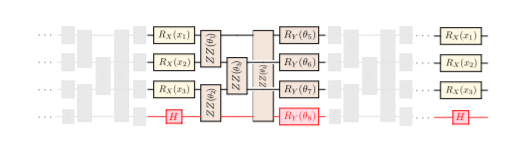

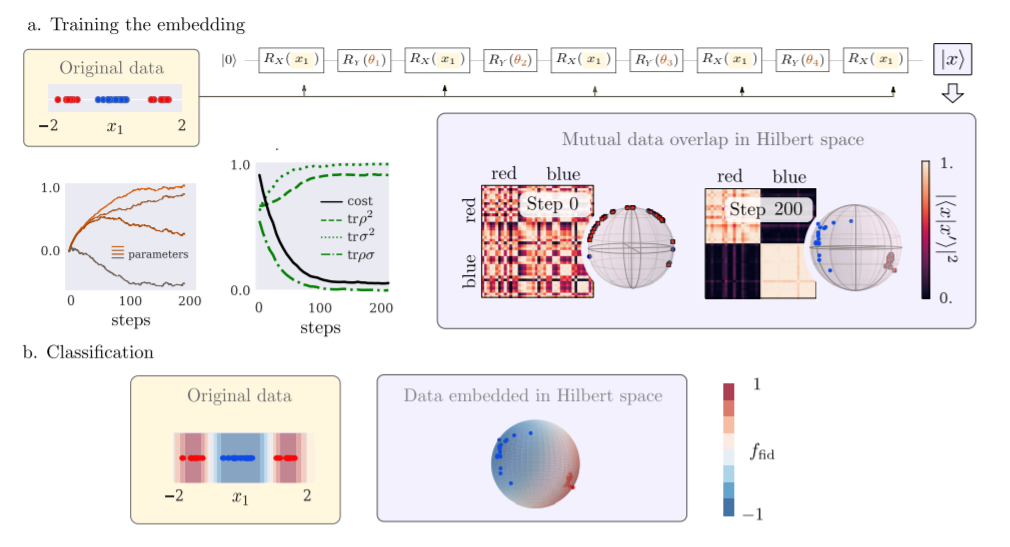

It has been implemented in a photonic quantum computer, but it could also be implemented in a superconducting quantum computer and make the feature map to be trainable to separate the data points in the higher dimension Hilbert space.

<div class="alert alert-block alert-success">
    <b>Conclusion:</b> <i>quantum feature map</i> is the most important step into quantum machine learning to obtain a good quantum model. The solutions of the quantum model rely how good the quantum encoding have been performed for the specific data. So this strategy is a very important matter to take into account in <b>Quantum Machine Learning</b>. One more aspect to remark is that amplitude encoding is an efficient way to encode the data, but it relys on developing very depth quantum circuits to change the initial state to a desire wavefunction (it has a lot of computational cost). Because of this, it has been demonstrated for NISQ devices the entanglement and Z-basis rotation basis is one of the best for quantum binary classification.
</div>

## Reference

https://pennylane.ai/qml/glossary/quantum_feature_map.html

https://pennylane.ai/qml/glossary/quantum_embedding.html

https://arxiv.org/pdf/1804.11326.pdf

https://pennylane.readthedocs.io/en/stable/code/qml_templates.html

https://arxiv.org/pdf/1803.07128.pdf

https://arxiv.org/pdf/2001.03622.pdf

https://pennylane.ai/qml/glossary/variational_circuit.html